# Automated Sensitivity, v17

## Load packages.

In [1]:
require(data.table)
require(deSolve)
require(magrittr)
require(SobolSequence)

require(ggplot2)
#require(GGally)

Loading required package: data.table
Loading required package: deSolve
Loading required package: magrittr
Loading required package: SobolSequence
Loading required package: ggplot2


## Function to generate simulations.

In [2]:
# Create a multivariate function with specified properties:
#   tmax: maximum time
#   multiplicities: number of correlations each parameter has
#   degrees: polynomial degree of each parameter
#   dimension: the dimension of the output
#   returns a multivariate function of the vector of parameters and time
makeGenerator <- function(multiplicities, degrees, dimension) {

    single <- function(degree) {
      x0 <- runif(1)
      z0 <- runif(1)
      print(paste("Critical point at x = ", x0, sep = ""))
      function(x) {
          if (x < x0)
              0
          else
              z0 * (x - x0)^degree
      }
    }
  
    locations <- lapply(multiplicities, function(m) sample(1:dimension, m))
    functions <- lapply(degrees, single)
    
    start <- runif(dimension, -0.25, 0.75)
    coefs <- matrix(runif(dimension^2, -0.25, 0.75), dimension, dimension)    
    shift <- matrix(runif(dimension^2, -0.25, 0.75), dimension, dimension)
    
    function(x, ts) {
        z <- rep(0, dimension)
        for (i in 1:length(locations))
            for (j in locations[[i]])
                z[j] <- z[j] + functions[[i]](x[i])
        ode(start, ts, function(t, y, params) {list((coefs %*% y) * z * (1 - ((shift %*% y) * z)))})
    }
    
}


## Reproducible random numbers.

In [3]:
RNGkind("Mersenne-Twister", "Inversion", "Rejection")

In [4]:
set.seed(46)

## Create a simulation function.

In [5]:
f <- makeGenerator(c(2, 2, 3), c(0, 1, 2), 3)

[1] "Critical point at x = 0.593385165324435"
[1] "Critical point at x = 0.948547213338315"
[1] "Critical point at x = 0.102978735696524"


## Functions for adapative sensitivity analysis.

### Initialize the design.

In [6]:
ssa.initialize <- function(n, f, ts) {
    k <- 3
    design <- sobolSequence.points(2 * k, count = n)[, 1:(2*k)]
    colnames(design) <- c("xa1", "xa2", "xa3", "xb1", "xb2", "xb3")
    list(
        f  = f
    ,   ts = ts
    ,   n  = n
    ,   k  = 3
    ,   m  = 3
    ,   x  = data.table(j = 1:nrow(design), design)
    ,   y  = data.table(
            j    = integer()
        ,   i    = integer()
        ,   l    = integer()
        ,   ya   = numeric()
        ,   yb   = numeric()
        ,   yaib = numeric()
        )

    )
}

### Update the evaluations.

In [7]:
ssa.evaluate <- function(ssa) {
    for (row in setdiff(ssa$x$j, unique(ssa$y$j))) {
        ya   <- ssa$f(as.numeric(ssa$x[row, .(xa1, xa2, xa3)]), ssa$ts)[length(ssa$ts), 1 + 1:ssa$m]
        yb   <- ssa$f(as.numeric(ssa$x[row, .(xb1, xb2, xb3)]), ssa$ts)[length(ssa$ts), 1 + 1:ssa$m]
        ya1b <- ssa$f(as.numeric(ssa$x[row, .(xb1, xa2, xa3)]), ssa$ts)[length(ssa$ts), 1 + 1:ssa$m]
        ya2b <- ssa$f(as.numeric(ssa$x[row, .(xa1, xb2, xa3)]), ssa$ts)[length(ssa$ts), 1 + 1:ssa$m]
        ya3b <- ssa$f(as.numeric(ssa$x[row, .(xa1, xa2, xb3)]), ssa$ts)[length(ssa$ts), 1 + 1:ssa$m]
        ssa$y <- rbind(
            ssa$y,
            data.table(
                j    = row
            ,   i    = rep(1:ssa$k, each  = ssa$m)
            ,   l    = rep(1:ssa$m, times = ssa$k)
            ,   ya   = rep(ya     , times = ssa$m)
            ,   yb   = rep(yb     , times = ssa$m)
            ,   yaib = c(ya1b, ya2b, ya3b)
            )
        )
    }
    ssa
}

### Compute local sensitivities.

In [8]:
ssa.sensitivity.local <- function(ssa, alpha = 2) {
    st <- merge(
        merge(rbind(
            ssa$x[, .(j, i = 1, xa = xa1, xb = xb1)]
        ,   ssa$x[, .(j, i = 2, xa = xa2, xb = xb2)]
        ,   ssa$x[, .(j, i = 3, xa = xa3, xb = xb3)]
        ), ssa$y)
    ,   ssa$y[i == 1, .(scale = sum(abs(ya - yb)^alpha)), by = .(l)]
    ,   by = "l"
    )[, .(
        j, i, l
    ,   xa, xb
    ,   s = abs(yb - yaib)^alpha / scale
    ,   t = abs(ya - yaib)^alpha / scale
    )][order(j, i, l)]
    melt(
        melt(
            st[, .(
                Observation = j
            ,   Input       = paste("x", i, sep="_")
            ,   Output      = paste("y", l, sep="_")
            ,   a           = xa
            ,   b           = xb
            ,   First       = s
            ,   Total       = t
            )]
        ,   id.vars = c("Observation", "Input", "Output", "First", "Total")
        ,   variable.name = "Block"
        ,   value.name = "x"
        )
    ,   id.vars = c("Observation", "Input", "Output", "Block", "x")
    ,   variable.name = "Sensitivity"
    ,   value.name = "Index"
    )
}

### Compute global sensitivities.

In [9]:
ssa.sensitivity.global <- function(local) {
    dcast(
        local[Block == "a", .(Index = sum(Index)), by = .(Input, Output, Sensitivity)]
    ,   Input + Output ~ Sensitivity
    ,   value.var = "Index"
    )[, .(Input, Output, First = 1 - First, Total)]
}

### Compute the sensitivity density.

In [10]:
ssa.sensitivity.density <- function(local, epsilon = 1e-4) {
    density <- local[
        Sensitivity == "Total" # & Index > 0
    ,   .(
            xmin   = min(x) - epsilon / 2
        ,   xmax   = max(x) + epsilon / 2
        ,   Index  = mean(Index)
        ,   Weight = 1
        )
    ,   by = .(Input, Output, Observation)
    ][, .(
        Input
    ,   Output
    ,   xmin
    ,   xmax
    ,   Index  = Index  / (xmax - xmin + epsilon)
    ,   Weight = Weight / (xmax - xmin + epsilon)
    )]
    rbind(
        density[, .(x = xmin, Index          , Weight           ), by = .(Input, Output)]
    ,   density[, .(x = xmax, Index = - Index, Weight = - Weight), by = .(Input, Output)]
    )[order(x)][, .(x, Index = cumsum(Index), Weight = cumsum(Weight)), by = .(Input, Output)]
}

### Compute metric for sensitivity-based sampling.

In [11]:
ssa.metric <- function(density) {
    metric <- density[
        , .(Density = sum(Index) / (sum(Weight) + 1e-10)), by = .(Input, Output, x)
    ]
    merge(
        metric
    ,   metric[, .(Scale = sum(Density)), by = .(Input, Output)]
    )[
        , .(Density = Density / Scale), by = .(Input, Output, x)
    ][
        , .(Density = mean(Density)), by = .(Input, x)
    ][
        order(Input, x)
    ][
        , .(x, Density, Cumulative = cumsum(Density)), by = Input
    ]
}

### Expand the experiment based on a sensitivity metric.

In [12]:
ssa.expand <- function(ssa, metric, n, beta = 0.5) {
    design <- sobolSequence.points(2 * ssa$k, count = ssa$n + n)[ssa$n + 1:n, 1:(2*ssa$k)]
    f <- function(x_i, xsample) {
        mapply(
            function(x, y)
                if (runif(1) <= beta) y else x
        ,   xsample
        ,   approx(
                c(0, metric[Input == x_i, Cumulative], 1)
            ,   c(0, metric[Input == x_i, x         ], 1)
            ,   xsample
            ,   rule = 2
            ,   ties = "ordered"
            )$y
        )
    }
    ssa$x <- rbind(
        ssa$x
    ,   data.table(
            j = ssa$n + 1:n
        ,   xa1 = f("x_1", design[, 1])
        ,   xa2 = f("x_2", design[, 2])
        ,   xa3 = f("x_3", design[, 3])
        ,   xb1 = f("x_1", design[, 4])
        ,   xb2 = f("x_2", design[, 5])
        ,   xb3 = f("x_3", design[, 6])
        )
    )
    ssa$n <- ssa$n + n
    ssa
}

## Single large batch.

### Initialize.

In [13]:
w <- ssa.initialize(1000, f, (0:20) / 2)

In [14]:
w <- ssa.evaluate(w)

#### Global sensitivities.

In [15]:
w.local <- ssa.sensitivity.local(w, alpha = 2)
ssa.sensitivity.global(w.local)

Input,Output,First,Total
<chr>,<chr>,<dbl>,<dbl>
x_1,y_1,0.0073512564,1.681385e-02
x_1,y_2,0.6206264739,9.369532e-01
x_1,y_3,0.1338078530,4.060176e-01
x_2,y_1,-0.0002645010,9.199686e-05
x_2,y_2,0.0001284894,5.162211e-05
x_2,y_3,0.0001398304,1.188286e-04
x_3,y_1,0.9828685869,9.925200e-01
x_3,y_2,0.0578912864,3.802736e-01
x_3,y_3,0.5908554512,8.664557e-01


#### Cumulative total sensitivity.

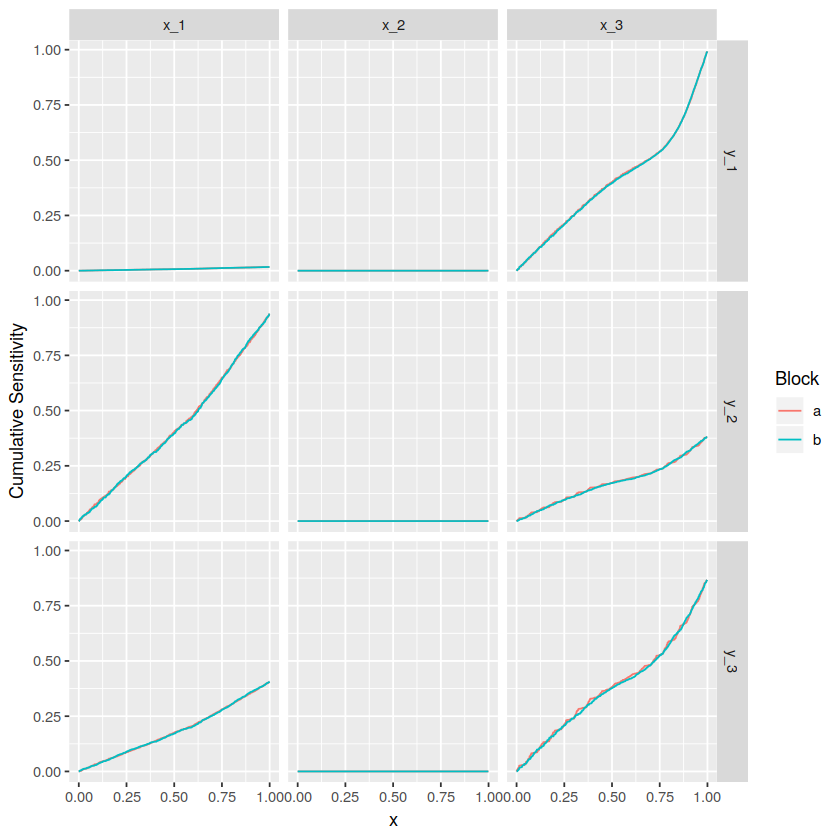

In [16]:
ggplot(
    w.local[
        Sensitivity == "Total"
    ][
        order(Input, Output, Block, x)
    ][
        , .(x, `Cumulative Sensitivity` = cumsum(Index)), by = .(Input, Output, Block)
    ]
,   aes(x = x, y = `Cumulative Sensitivity`, color = Block)
) +
geom_line() +
facet_grid(Output ~ Input)

#### Sensitivity density.

Warning message:
“Removed 1 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 1 rows containing missing values (geom_smooth).”

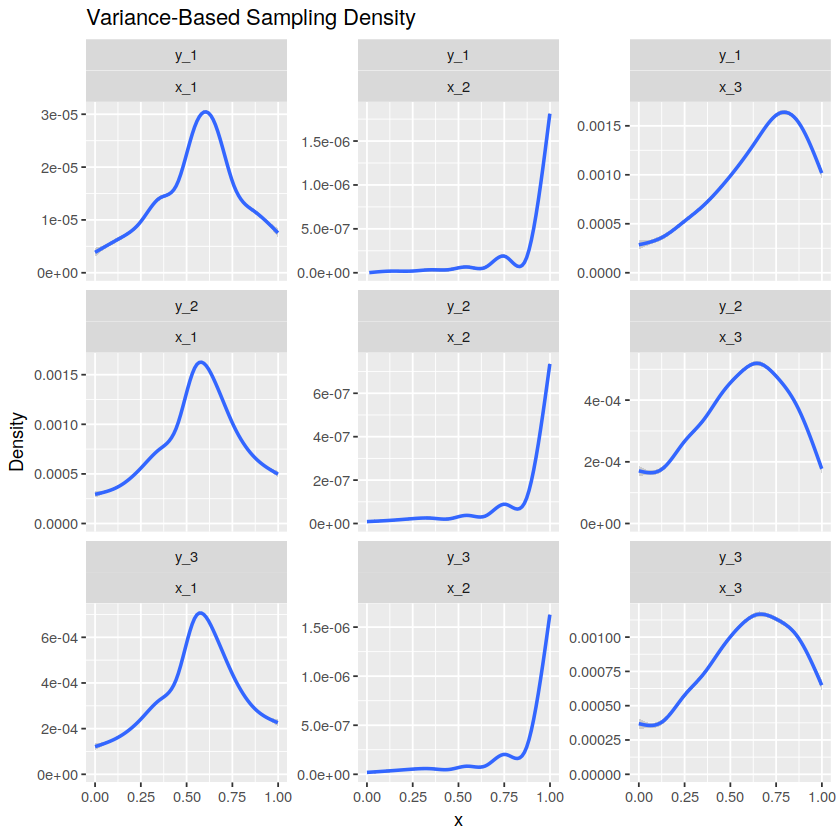

In [17]:
w.density <- ssa.sensitivity.density(w.local)
ggplot(
    w.density[
        , .(Density = sum(Index) / (sum(Weight) + 1e-10)), by = .(Input, Output, x)
    ][
        order(Input, Output, x)
    ]
,   aes(x = x, y = Density)
) +
geom_smooth(method = "gam", formula = y ~ s(x, bs = "cs")) +
scale_y_continuous(limits = c(0, NA)) +
facet_wrap(Output ~ Input, scales = "free_y") +
ggtitle("Variance-Based Sampling Density")

#### Metric for sampling.

Warning message:
“Removed 1 rows containing non-finite values (stat_smooth).”

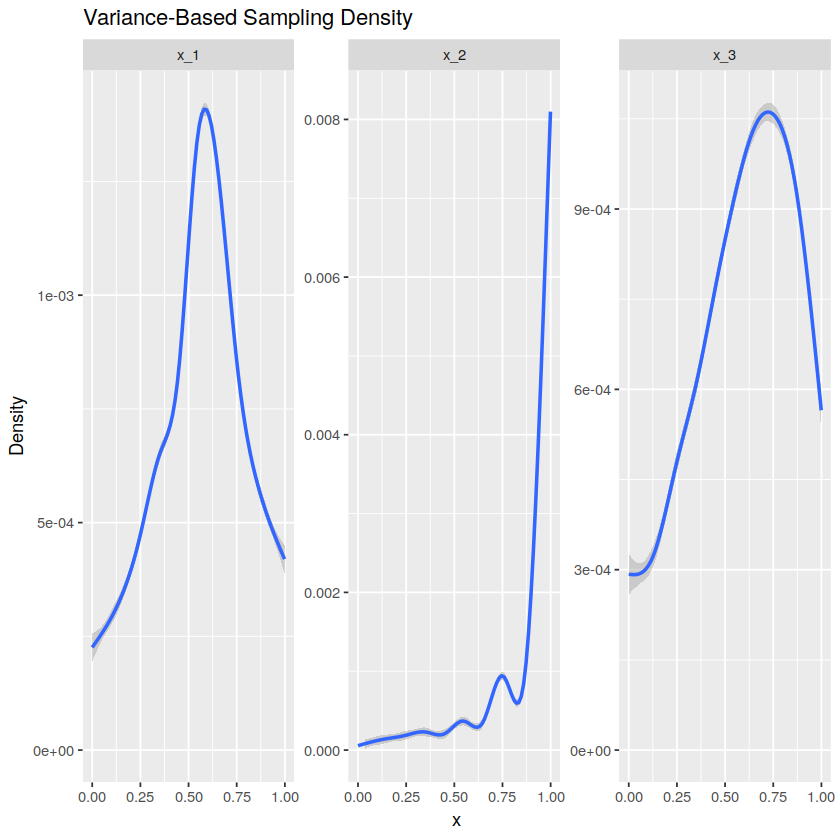

In [18]:
w.metric <- ssa.metric(w.density)
ggplot(
    w.metric
,   aes(x = x, y = Density)
) +
geom_smooth(method = "gam", formula = y ~ s(x, bs = "cs")) +
scale_y_continuous(limits = c(0, NA)) +
facet_wrap(. ~ Input, scales = "free_y") +
ggtitle("Variance-Based Sampling Density")

## Small sequential batches.

### Batch size.

In [19]:
dn <- 10

### Initialize.

In [20]:
z <- ssa.initialize(dn, f, (0:20) / 2)

In [21]:
z <- ssa.evaluate(z)

#### Initial sensitivity density.

Warning message:
“Removed 6 rows containing missing values (geom_smooth).”

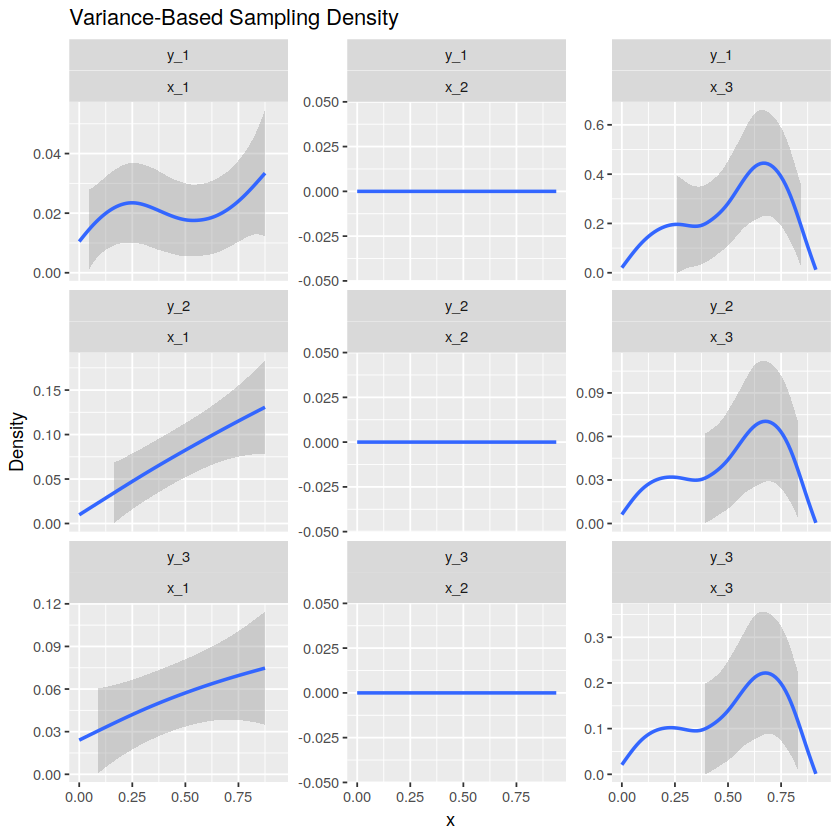

In [22]:
z.local <- ssa.sensitivity.local(z, alpha = 2)
z.density <- ssa.sensitivity.density(z.local)
ggplot(
    z.density[
        , .(Density = sum(Index) / (sum(Weight) + 1e-10)), by = .(Input, Output, x)
    ][
        order(Input, Output, x)
    ]
,   aes(x = x, y = Density)
) +
geom_smooth(method = "gam", formula = y ~ s(x, bs = "cs")) +
scale_y_continuous(limits = c(0, NA)) +
facet_wrap(Output ~ Input, scales = "free_y") +
ggtitle("Variance-Based Sampling Density")

### Iterate.

In [23]:
for (p in 1:99) {
    z.local <- ssa.sensitivity.local(z, alpha = 2)
    z.density <- ssa.sensitivity.density(z.local)
    z.metric <- ssa.metric(z.density)
    z <- ssa.expand(z, z.metric, dn, beta = 0.5)
    z <- ssa.evaluate(z)
}

#### Global sensitivities.

In [24]:
ssa.sensitivity.global(z.local)

Input,Output,First,Total
<chr>,<chr>,<dbl>,<dbl>
x_1,y_1,0.0133724482,0.0218886918
x_1,y_2,0.5818574836,0.8974174241
x_1,y_3,0.0983086181,0.3605415014
x_2,y_1,-0.0004306457,0.0002631658
x_2,y_2,0.0003878962,0.0001726690
x_2,y_3,0.0007016515,0.0003760448
x_3,y_1,0.9783393595,0.9863405787
x_3,y_2,0.0804623190,0.4253513241
x_3,y_3,0.6272739778,0.9114314591


#### Final cumulative total sensitivity.

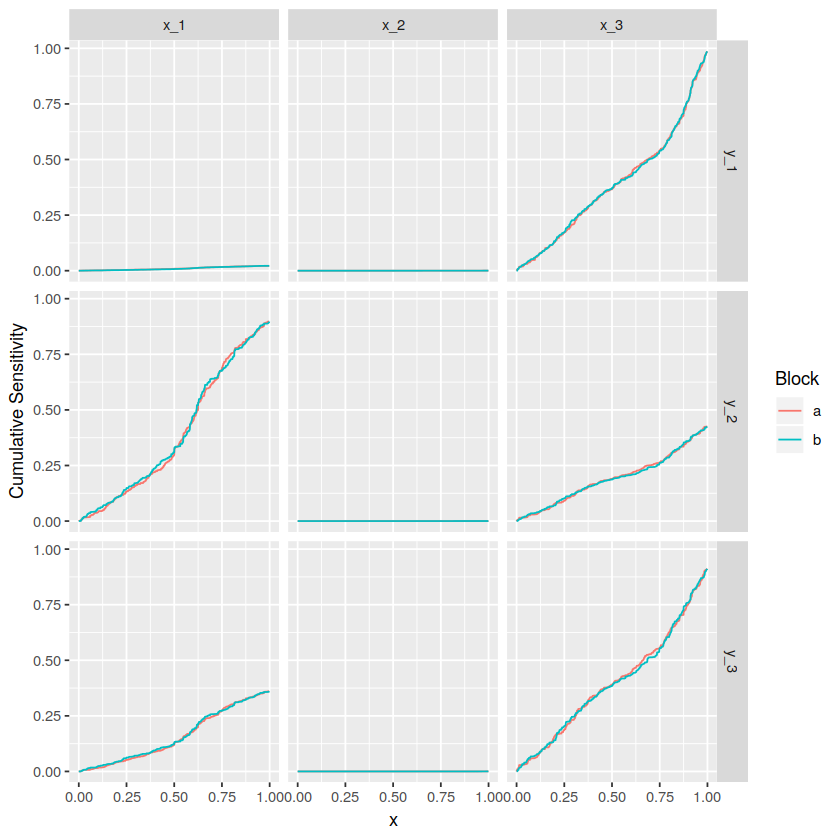

In [25]:
ggplot(
    z.local[
        Sensitivity == "Total"
    ][
        order(Input, Output, Block, x)
    ][
        , .(x, `Cumulative Sensitivity` = cumsum(Index)), by = .(Input, Output, Block)
    ]
,   aes(x = x, y = `Cumulative Sensitivity`, color = Block)
) +
geom_line() +
facet_grid(Output ~ Input)

#### Final sensitivity density.

Warning message:
“Removed 2 rows containing non-finite values (stat_smooth).”

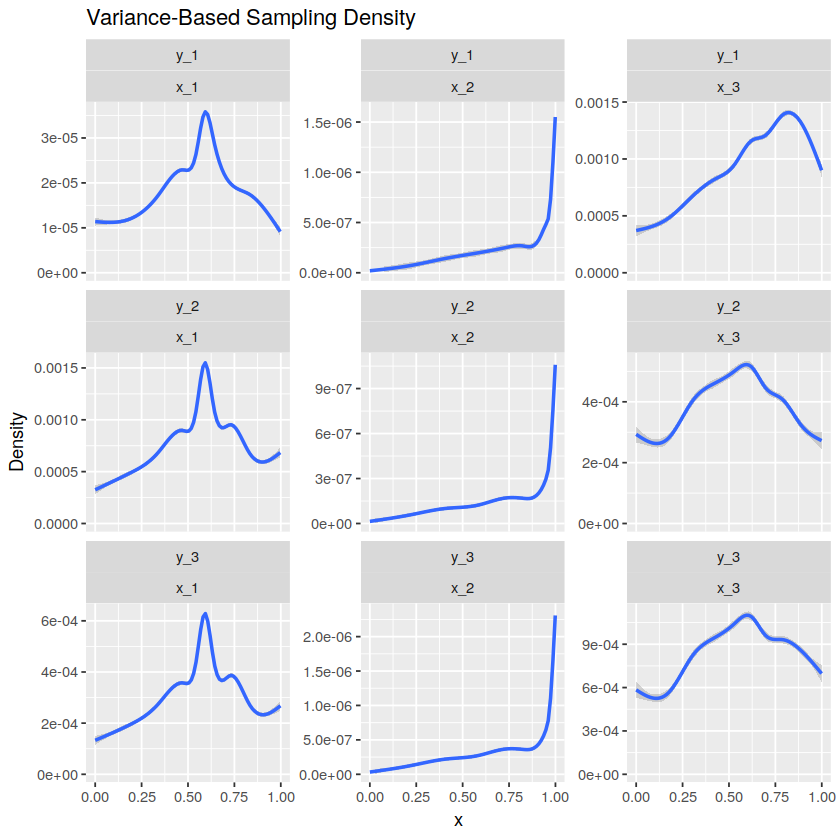

In [26]:
ggplot(
    z.density[
        , .(Density = sum(Index) / (sum(Weight) + 1e-10)), by = .(Input, Output, x)
    ][
        order(Input, Output, x)
    ]
,   aes(x = x, y = Density)
) +
geom_smooth(method = "gam", formula = y ~ s(x, bs = "cs")) +
scale_y_continuous(limits = c(0, NA)) +
facet_wrap(Output ~ Input, scales = "free_y") +
ggtitle("Variance-Based Sampling Density")

#### Final metric for sampling.

Warning message:
“Removed 1 rows containing non-finite values (stat_smooth).”

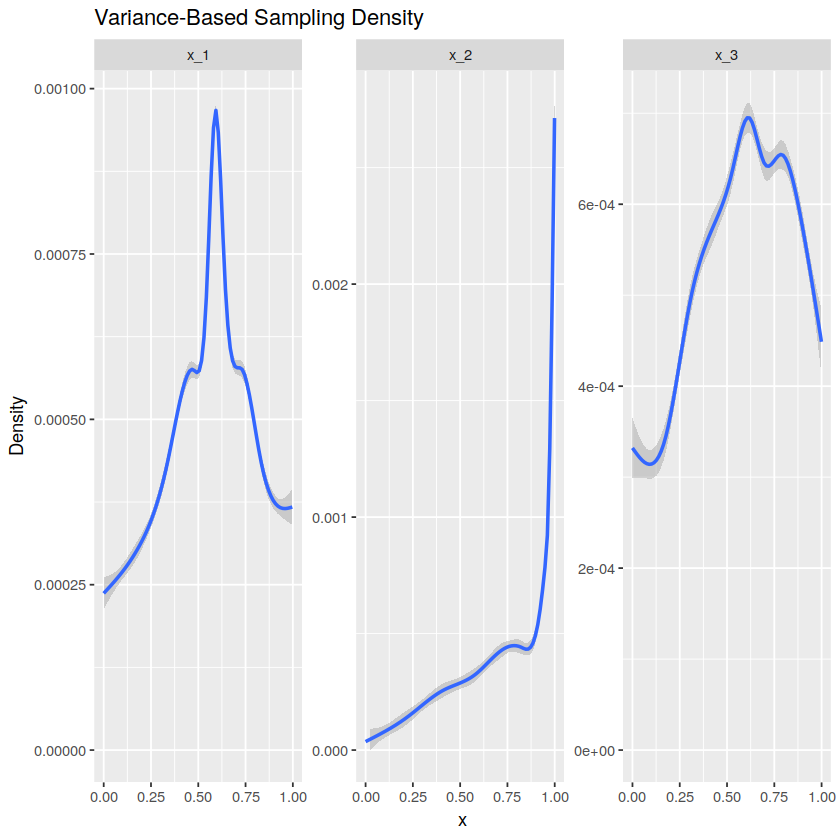

In [27]:
ggplot(
    z.metric
,   aes(x = x, y = Density)
) +
geom_smooth(method = "gam", formula = y ~ s(x, bs = "cs")) +
scale_y_continuous(limits = c(0, NA)) +
facet_wrap(. ~ Input, scales = "free_y") +
ggtitle("Variance-Based Sampling Density")

#### Histogram of $x_1$.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


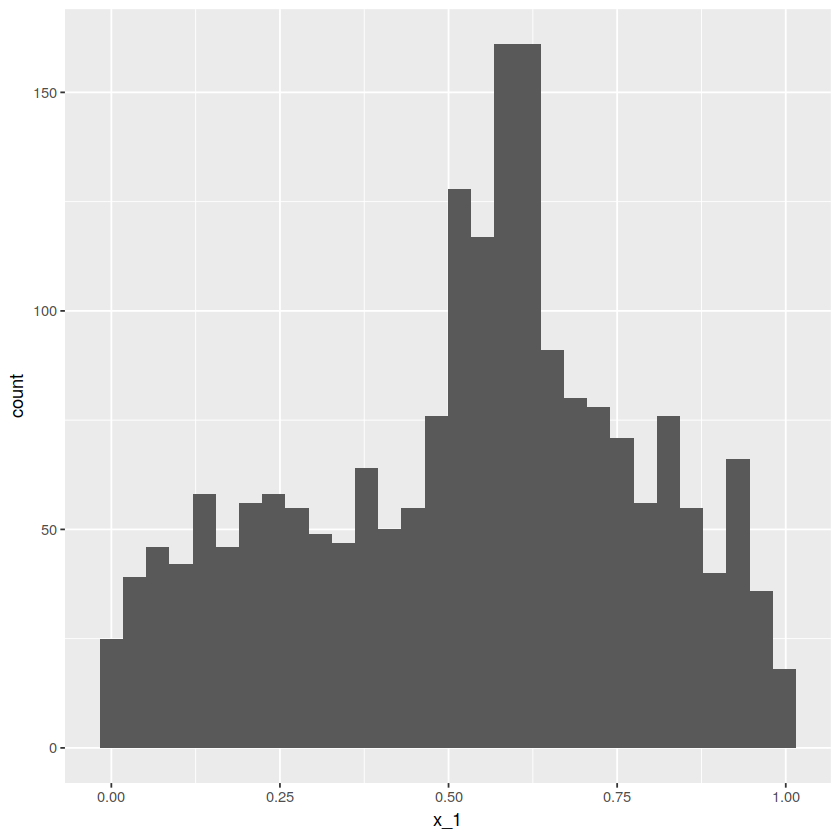

In [28]:
ggplot(
    rbind(
        z$x[, .(Batch = ceiling(j / dn), x_1 = xa1, x_2 = xa2, x_3 = xa3)]
    ,   z$x[, .(Batch = ceiling(j / dn), x_1 = xb1, x_2 = xb2, x_3 = xb3)]
    )
,   aes(x = x_1)
) + geom_histogram()

#### Histogram of $x_2$.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


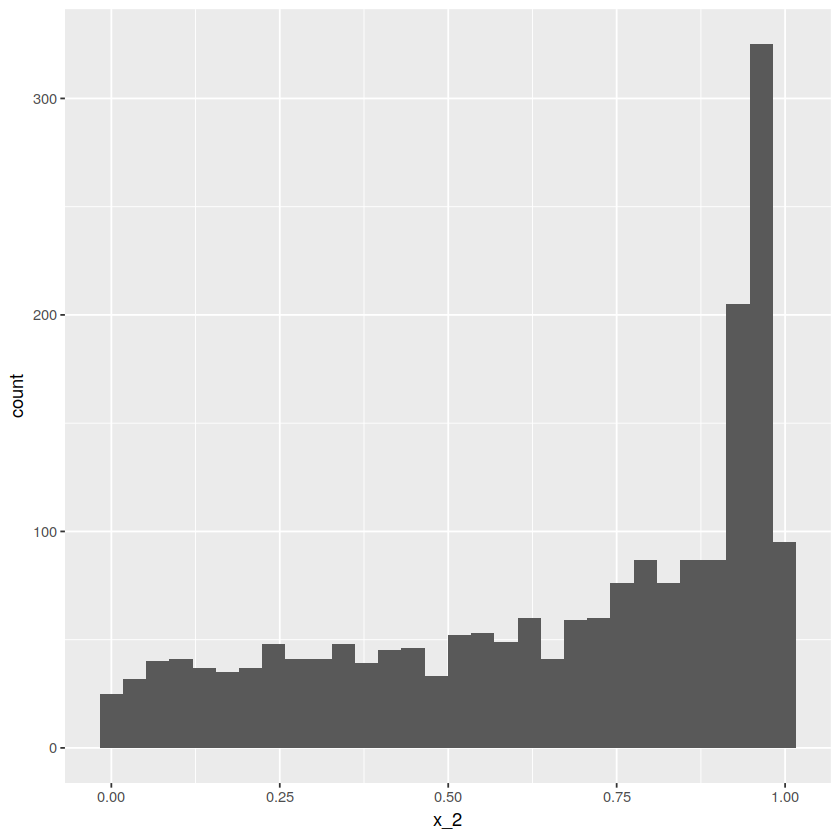

In [29]:
ggplot(
    rbind(
        z$x[, .(Batch = ceiling(j / dn), x_1 = xa1, x_2 = xa2, x_3 = xa3)]
    ,   z$x[, .(Batch = ceiling(j / dn), x_1 = xb1, x_2 = xb2, x_3 = xb3)]
    )
,   aes(x = x_2)
) + geom_histogram()

#### Histogram of $x_3$.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


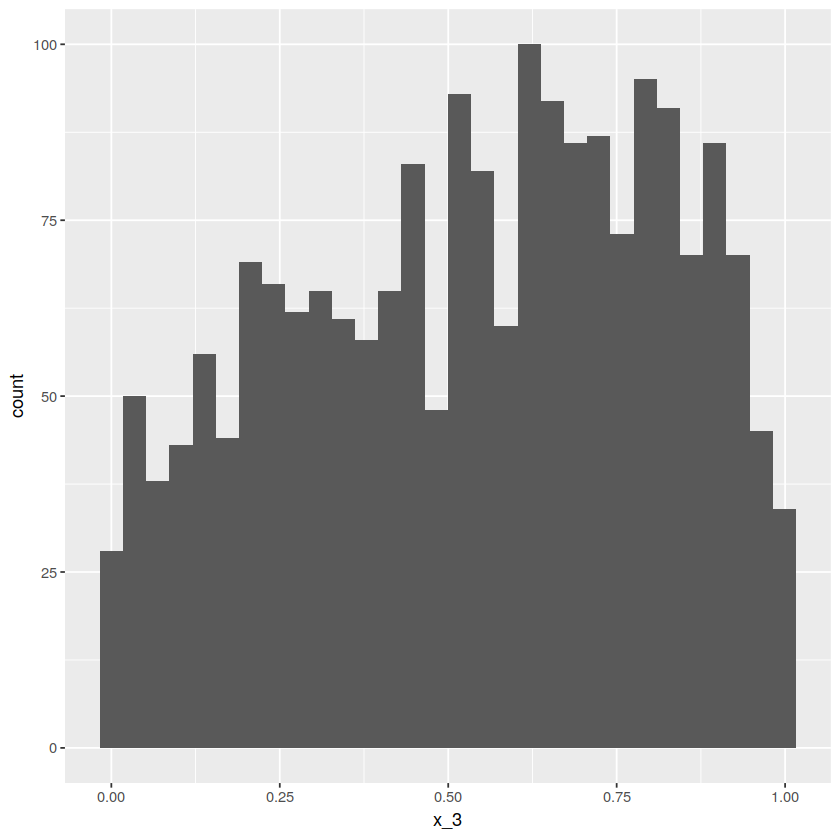

In [30]:
ggplot(
    rbind(
        z$x[, .(Batch = ceiling(j / dn), x_1 = xa1, x_2 = xa2, x_3 = xa3)]
    ,   z$x[, .(Batch = ceiling(j / dn), x_1 = xb1, x_2 = xb2, x_3 = xb3)]
    )
,   aes(x = x_3)
) + geom_histogram()

#### $x_1$ vs $x_2$.

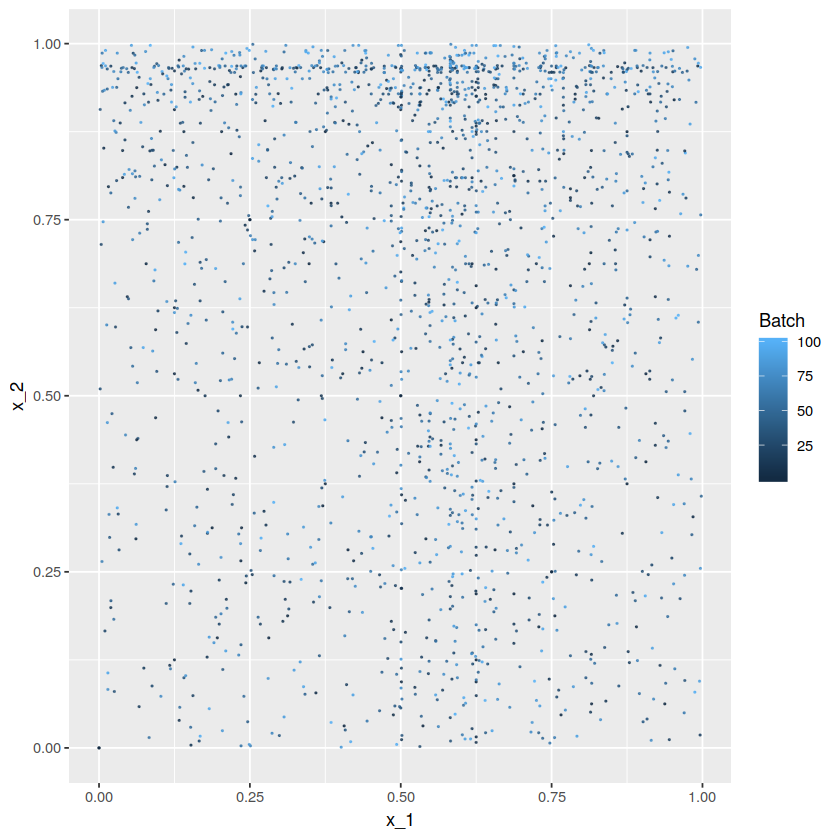

In [31]:
ggplot(
    rbind(
        z$x[, .(Batch = ceiling(j / dn), x_1 = xa1, x_2 = xa2, x_3 = xa3)]
    ,   z$x[, .(Batch = ceiling(j / dn), x_1 = xb1, x_2 = xb2, x_3 = xb3)]
    )
,   aes(x = x_1, y = x_2, color = Batch)
) + geom_point(size = 0.25, alpha = 0.75)

#### $x_2$ vs $x_3$.

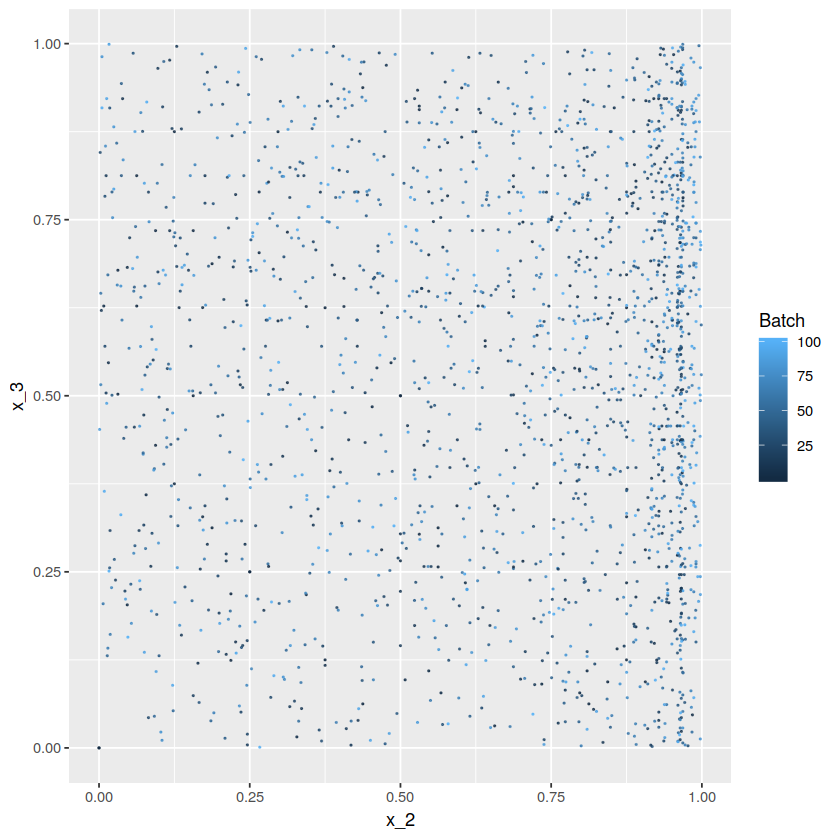

In [32]:
ggplot(
    rbind(
        z$x[, .(Batch = ceiling(j / dn), x_1 = xa1, x_2 = xa2, x_3 = xa3)]
    ,   z$x[, .(Batch = ceiling(j / dn), x_1 = xb1, x_2 = xb2, x_3 = xb3)]
    )
,   aes(x = x_2, y = x_3, color = Batch)
) + geom_point(size = 0.25, alpha = 0.75)

#### $x_3$ vs $x_1$.

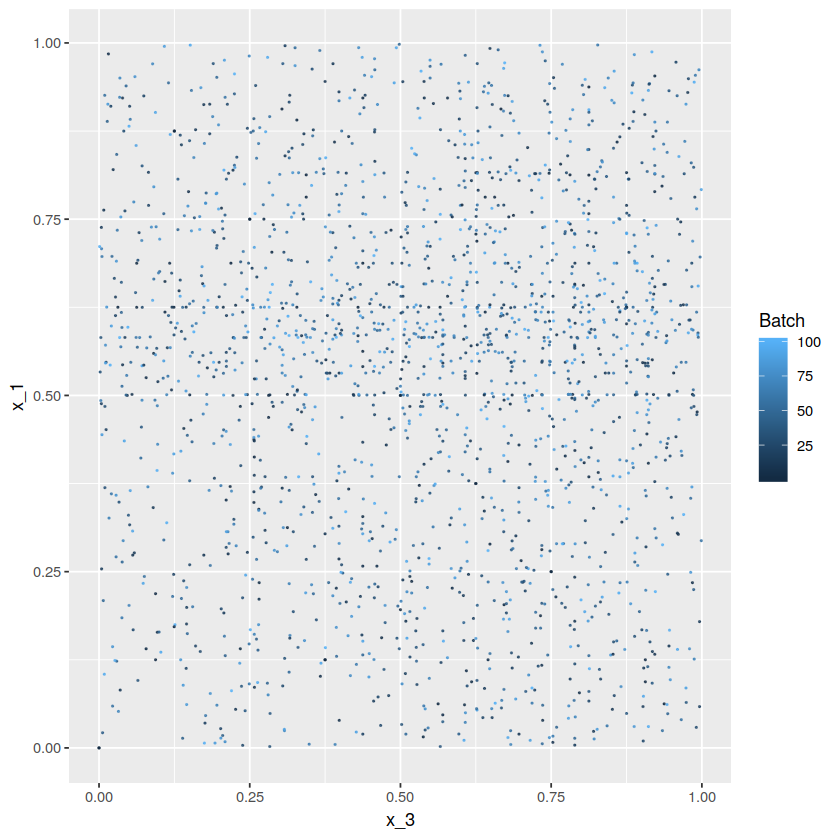

In [33]:
ggplot(
    rbind(
        z$x[, .(Batch = ceiling(j / dn), x_1 = xa1, x_2 = xa2, x_3 = xa3)]
    ,   z$x[, .(Batch = ceiling(j / dn), x_1 = xb1, x_2 = xb2, x_3 = xb3)]
    )
,   aes(x = x_3, y = x_1, color = Batch)
) + geom_point(size = 0.25, alpha = 0.75)